In [1]:
import numpy as np
import pandas as pd
import random as python_random
import shutil
import os
import datetime
import skimage
import cv2 as cv
from cv2 import THRESH_OTSU
import mediapipe as mp
from datetime import datetime
from skimage import io
from PIL import Image
from multiprocessing import cpu_count
from joblib import Parallel, delayed
from collections import Counter
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error
from skimage.transform import rescale, resize, downscale_local_mean
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
import skimage
from skimage import color
from skimage.transform import rescale, resize

# for reproducibility purposes
SEED = 123
tf.random.set_seed(SEED)
classes=['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']

# load tensorboard extension
%reload_ext tensorboard
# specify the log directory where the tensorboard logs will be written
%tensorboard --logdir logs

2022-04-21 20:24:22.049786: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


Reusing TensorBoard on port 6006 (pid 40389), started 1 day, 3:48:43 ago. (Use '!kill 40389' to kill it.)

Found 11408 images belonging to 26 classes.
Found 2839 images belonging to 26 classes.


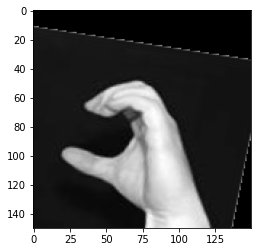

In [2]:
img_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=30.0,
    width_shift_range=25.0,
    height_shift_range=25.0,
    shear_range=0.1,
    zoom_range=.2,
    fill_mode='constant',
    horizontal_flip=True,
    vertical_flip=False,
    validation_split=0.2
    
)

train_generator = img_generator.flow_from_directory(
  './custom_dataset',
  target_size=(150,150),
  color_mode='grayscale',
  classes=classes,
  class_mode='categorical',
  seed=SEED,
  shuffle=False,
  subset='training'
)

val_generator = img_generator.flow_from_directory(
  './custom_dataset',
  target_size=(150,150),
  color_mode='grayscale',
  classes=classes,
  class_mode='categorical',
  seed=SEED,
  shuffle=False,
  subset='validation'
)

for i, image in enumerate(val_generator):
  if i == 5:
    plt.imshow(image[0][1], cmap = 'gray')
    break



In [3]:
def make_directories():
    d = datetime.today()
    timestamp = d.strftime('%Y%m%d_%H%M%S')
    # folder to store the tensorboard logs
    tensorlog_folder = os.path.join(os.path.curdir, 'logs', timestamp)
    # folder to store the trained models
    checkpoint_folder = os.path.join(os.path.curdir, 'models', timestamp)

    os.mkdir(tensorlog_folder)
    os.mkdir(checkpoint_folder)

    return checkpoint_folder, tensorlog_folder

In [61]:
check_dir, tboard_dir = make_directories()

input = keras.Input(shape=(150, 150, 1))
layer1 = tf.keras.layers.Conv2D(16, (4,4), activation= 'relu', name="layer1")
layer2 = tf.keras.layers.Conv2D(16, (4,4), activation= 'relu', name="layer2")
layer3 = tf.keras.layers.MaxPool2D((2,2), name="layer3")
layer4 = tf.keras.layers.Conv2D(32, (4,4), activation= 'relu', name="layer4")
layer5 = tf.keras.layers.Conv2D(32, (4,4), activation= 'relu', name="layer5")
layer6 = tf.keras.layers.MaxPool2D((2,2), name="layer6")
layer7 = tf.keras.layers.Flatten(name="layer7")
layer8 = tf.keras.layers.Dense(128, activation='relu', name='layer8')
layer9 = tf.keras.layers.Dense(128, activation='relu', name='layer9')
# layer6 = tf.keras.layers.Dense(128, activation='relu', name='layer6')

output =  tf.keras.layers.Dense(len(classes), activation='softmax', name='symbol')

network = output(layer9(layer8(layer7(layer6(layer5(layer4(layer3(layer3(layer2(layer1(input)))))))))))

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)

model = tf.keras.Model(inputs=input, outputs=network, name="Logan")


model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              loss_weights=[0.01],
              metrics=[tf.keras.metrics.top_k_categorical_accuracy, 'accuracy'],
              )


early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)
checkpoints = keras.callbacks.ModelCheckpoint(
    filepath=check_dir,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False
)
tensorboard = keras.callbacks.TensorBoard(
    log_dir=tboard_dir
)
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    min_lr=1e-5,
    verbose=1
)

callbacks = [checkpoints, early_stop, tensorboard, reduce_lr]

# fit the model with training and validation generators
# In addition please specify the following arguments
# steps_per_epoch=len(df_train)/batch_size
# validation_steps=len(df_val)/batch_size
# (5)
print(model.summary())
# tf.keras.utils.plot_model(
#     model,
#     show_shapes=True,
#     show_dtype=False,
#     show_layer_names=True,
#     rankdir="TB",
#     expand_nested=False,
#     dpi=96,
#     layer_range=None,
#     show_layer_activations=False)
model.fit(
        train_generator,
        epochs=100,
        validation_data=val_generator,
        batch_size=16, 
        callbacks=callbacks,
        # steps_per_epoch=len(train)/batch_size,
        # validation_steps=len(val)/batch_size
        )




Model: "Logan"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 1) 0                                            
__________________________________________________________________________________________________
layer1 (Conv2D)                 (None, 147, 147, 16) 272         input_2[0][0]                    
__________________________________________________________________________________________________
layer2 (Conv2D)                 (None, 144, 144, 16) 4112        layer1[0][0]                     
__________________________________________________________________________________________________
layer3 (MaxPooling2D)           multiple             0           layer2[0][0]                     
                                                                 layer3[0][0]                 

In [75]:
model = tf.keras.models.load_model('./models/20220421_194054')

In [78]:
from sklearn.metrics import classification_report
test_img_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    width_shift_range=25.0,
    height_shift_range=25.0,
    horizontal_flip=True, 
)
test_generator = test_img_generator.flow_from_directory(
  './test_data',
  target_size=(150,150),
  color_mode='grayscale',
  classes=classes,
  class_mode='categorical',
  seed=SEED,
  shuffle=False,
)

y_pred = model.predict(test_generator, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(test_generator.classes, y_pred_bool))

Found 78 images belonging to 26 classes.
3/3 [==============================] - 0s 137ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.08      0.33      0.13         3
           2       0.00      0.00      0.00         3
           3       0.50      0.33      0.40         3
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00         3
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00         3
           9       0.00      0.00      0.00         3
          10       0.33      0.33      0.33         3
          11       0.00      0.00      0.00         3
          12       0.00      0.00      0.00         3
          13       0.00      0.00      0.00         3
          14       0.00      0.00      0.00         3
          15       0.25      0.33      0.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [79]:
# takes hand detection output to add bounding rectangles
def find_hands(current, width, height):
    rect_list = []
    hand_classifier = []
    center = (0,0)
    # iterates through hand tracking data per hand
    if current.multi_hand_landmarks:
        for index, info in enumerate(current.multi_handedness):
            which = info.classification[0].label
            hand_classifier.append(which)
        for index, hand in enumerate(current.multi_hand_landmarks):
            # values from 0 to 1 converted into values corresponding to video size
            hand_list = []
            for individual in hand.landmark:
                hand_list.append((int(individual.x * width), int(individual.y * height), int(individual.z * width)))
            # developing bounding box coordinates
            x_values = np.array(hand_list)[:, 0]
            y_values = np.array(hand_list)[:, 1]
            x_min = int(np.min(x_values) - 10)
            y_min = int(np.min(y_values) - 10)
            x_max = int(np.max(x_values) + 10)
            y_max = int(np.max(y_values) + 10)
            center = (x_min + (x_max-x_min)//2, y_min + (y_max-y_min)//2)
            rect_list.append(((x_min, y_min), (x_max, y_max), (0, 255, 0), hand_classifier[index]))
    return rect_list, center

In [98]:
def capture():
    video = cv.VideoCapture(0, cv.CAP_DSHOW) #captureDevice = camera
    running, original = video.read()
    h, w, _ = original.shape    
    # machine learning algorithm (using mediapipe, via google)
    # init_hands = mp.solutions.hands
    # hands = init_hands.Hands()
    hands = mp.solutions.hands.Hands()
    savedFrames = []
    # continuous looping
    while True:
        running, original = video.read()
        if not running:
            break
        # hand processing
        track_curr = hands.process(original)
        # calculating bounding rectangles
        current_rects, center = find_hands(track_curr, w, h)

        if current_rects:
          if len(current_rects) > 1:
            print('Please use only one hand')
          else:
            current_rect = current_rects[0]
            left = current_rect[0][0]
            right = current_rect[1][0]
            top = current_rect[0][1]
            bottom = current_rect[1][1]
            hand_width = right - left
            hand_height = bottom-top
            square_top_left = (center[0]-75,center[1]-75)
            square_bottom_right = (center[0]+75,center[1]+75)

            red = (0,0,255)
            green = (0,255,0)
            if hand_width <= 150 and hand_height <= 150:
              if top > 0 and left > 0 and bottom > 0 and right > 0:
                # cv.rectangle(original, current_rect[0], current_rect[1], green, 1)
                cv.rectangle(original,square_top_left ,square_bottom_right , green,1)
                crop = original[center[1]-75:center[1]+75,center[0]-75:center[0]+75]   
                savedFrames.append(crop)
              
                # cv.circle(original, center, 10, 2, 2)
            else:
              cv.rectangle(original, current_rect[0], current_rect[1], red, 2)
              cv.rectangle(original,square_top_left ,square_bottom_right , red,2)
              # print("You're too close! Back up!")
        cv.imshow("Video Feed", original)
        k = cv.waitKey(1) & 0xff
        if k == 27:
            break
    cv.destroyAllWindows()
    video.release()
    return savedFrames

Please use only one hand
Please use only one hand
Please use only one hand
Please use only one hand
Please use only one hand
Please use only one hand
Please use only one hand
Please use only one hand
Please use only one hand
Please use only one hand
Please use only one hand
Please use only one hand
Please use only one hand
Please use only one hand
Please use only one hand
Please use only one hand
Please use only one hand
Please use only one hand
Please use only one hand
Please use only one hand
Please use only one hand
Please use only one hand
Please use only one hand
Please use only one hand
Please use only one hand
Please use only one hand
Please use only one hand
Please use only one hand
1384
oaaaaaaaaaaaaaaaaassaaaaaaaaeeeeebbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbeeecccccccccccccccccccccccccccccccccccocccxxxxxxddrzurrzrrrrrrrrrrrrrrrruuuuuuuuurxzmssssssssssssssssssssssssssssseenebbbbeebeefeeeeeeeebeeeeeeeeeebeeaaxzpcccggcgggggggggggggggggggggggggggggggggggggggghhhhhhhhhhhhhhhhh

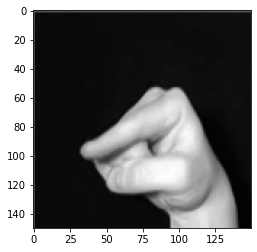

In [102]:
frames = capture()
def open_operation(ex_img):
    ex_img = cv.erode(ex_img, (11, 11))
    ex_img = cv.dilate(ex_img, (11, 11))
    return ex_img
def prepare_image(grayImg):
    img1 = cv.medianBlur(grayImg, 13)
    ex_img = open_operation(img1)
    ex_img = open_operation(ex_img)
    ex_img = open_operation(ex_img)
    return ex_img

def contrast(img):
    _, mask = cv.threshold(img, thresh=50, maxval=255, type=cv.THRESH_OTSU)
    ex_img = prepare_image(mask)
    res = cv.bitwise_and(img, ex_img)
    # cv.imshow("masked", res)
    # cv.imshow("mask", mask)
    # cv.imshow("unmasked", img)
    return res

def saveImg(img):
  im = Image.fromarray((img*255))
  plt.imshow(im, cmap = 'gray')
  if im.mode !='RGB':
    im = im.convert('RGB')
  im.save(f'./frames/{i}.png')

print(len(frames))
processedFrames= []
for i, frame in enumerate(frames):

  img = resize(frame, (150,150,1))
  img *= 255
  img = img.astype(np.uint8)
  # img = contrast(img)
  plt.imshow(img, cmap = 'gray')  
  # print(frame.type())
  x = tf.keras.preprocessing.image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
 
  processedFrames.append(x)
  # saveImg(img)


images = np.vstack(processedFrames)
predictions = model.predict(images)
output = ""
for prediction in predictions:
  classIndex = np.argmax(prediction)
  output += classes[classIndex]
print(output)
  # for i in range(len(predictions[0])):
  #   print(classes[i], predictions[0][i])




# lllllllllllllllllllllllllllllccooooooooooooooooooooooooooooooooooooooaaooqqcccgpggggggggqgqgggggg1gggggggggggggggggggcqaannnsassasaassssasaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaannnnnmnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnneee



In [103]:
strengths = [(output[0],1)]
for i in range(1, len(output)):
  if output[i] == output[i-1]:
    strengths[-1] = (strengths[-1][0],strengths[-1][1]+1)
  else:
    strengths.append((output[i],1))

print(strengths)
barrier = 10
final = ''

for letter in strengths:
  if letter[1] >= barrier:
    if len(final) > 0:
      if letter[0] != final[-1]:
        final += letter[0]
    else:
      final += letter[0]
print(final)


[('o', 1), ('a', 17), ('s', 2), ('a', 8), ('e', 5), ('b', 44), ('e', 3), ('c', 35), ('o', 1), ('c', 3), ('x', 6), ('d', 2), ('r', 1), ('z', 1), ('u', 1), ('r', 2), ('z', 1), ('r', 16), ('u', 9), ('r', 1), ('x', 1), ('z', 1), ('m', 1), ('s', 29), ('e', 2), ('n', 1), ('e', 1), ('b', 4), ('e', 2), ('b', 1), ('e', 2), ('f', 1), ('e', 8), ('b', 1), ('e', 10), ('b', 1), ('e', 2), ('a', 2), ('x', 1), ('z', 1), ('p', 1), ('c', 3), ('g', 2), ('c', 1), ('g', 40), ('h', 30), ('z', 3), ('j', 2), ('a', 1), ('e', 2), ('a', 1), ('i', 1), ('a', 1), ('i', 33), ('a', 1), ('j', 7), ('a', 4), ('i', 23), ('x', 1), ('i', 1), ('z', 1), ('j', 9), ('a', 4), ('j', 2), ('a', 2), ('i', 1), ('x', 1), ('i', 1), ('b', 2), ('k', 41), ('x', 3), ('l', 51), ('a', 1), ('m', 1), ('e', 1), ('a', 2), ('s', 10), ('a', 1), ('s', 10), ('a', 2), ('s', 1), ('m', 3), ('s', 22), ('a', 4), ('s', 7), ('m', 2), ('s', 5), ('o', 1), ('s', 6), ('a', 2), ('s', 1), ('a', 11), ('s', 1), ('a', 7), ('s', 1), ('a', 3), ('s', 3), ('a', 2), ('s

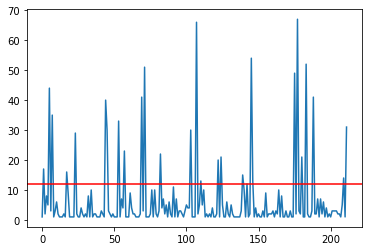

In [104]:
pureStrengths = []
for i in strengths:
  pureStrengths.append(i[1])

plt.plot(pureStrengths)
plt.axhline(y=barrier, color='r', linestyle='-')

plt.show()

As a test case, I signed "Logan" <br>
The frame by frame classification resulted in the following string: <br>
lllllllcllcllllllllllllllllllooooooooooooooooooooooooooczgggggggggggggggggggpgpgggggggggjppppppppclyeejjjjjjjjjsjjjegxgggggggggggzggxxxggcccxggxgggggxxmtmeeeeetttxggggxxxxxxxxxxxxxxeedzggxxxxxooo
<br>
After applying the grouping algorithm, the final string output was "logx" corrctly classing the first 3 letters
